In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statistics as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

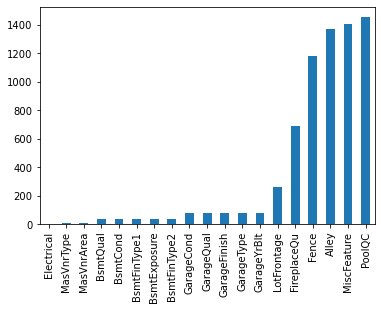

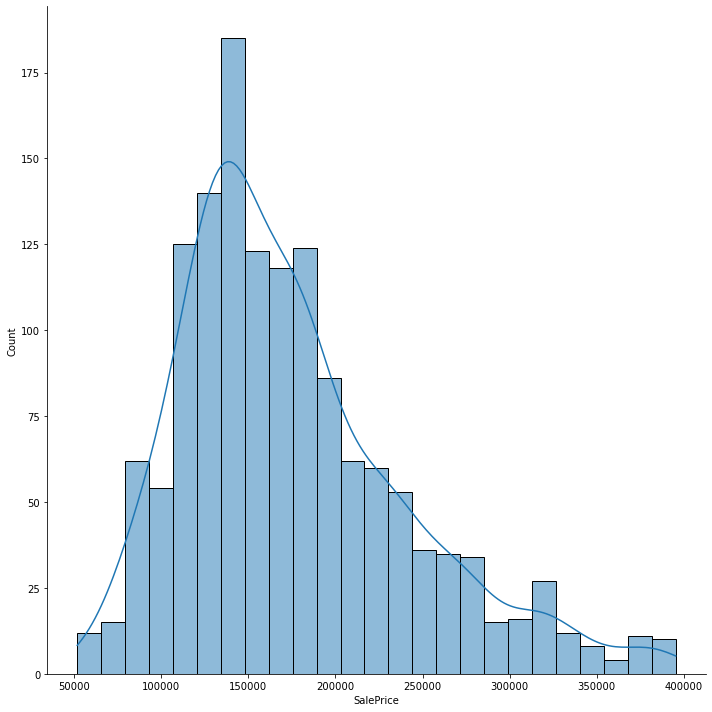

In [3]:
train = pd.read_csv('D:/houseprices/train.csv')
test = pd.read_csv('D:/houseprices/test.csv')     
sample = pd.read_csv('D:/houseprices/sample_submission.csv')

missing = train.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
missing.plot.bar()
c_drop = ['Alley', 'PoolQC', 'Fence', 'MiscFeature', 'Id']
train.drop(columns=c_drop, inplace=True)
test.drop(columns=c_drop, inplace=True)

qn = [cat for cat in train.columns if train.dtypes[cat] != 'object']
ql = [cat for cat in train.columns if train.dtypes[cat] == 'object']
qntest = [ct_test for ct_test in test.columns if test.dtypes[ct_test] != 'object']
qltest = [ct_test for ct_test in test.columns if test.dtypes[ct_test] == 'object']

for col in ql:
    train[col] = train[col].fillna(st.mode(train[col].dropna()))
for col in qn:
    train[col] = train[col].fillna(st.mode(train[col].dropna()))
for ct_test in ql:
    train[ct_test] = train[ct_test].fillna(st.mode(train[ct_test].dropna()))
for ct_test in qn:
    train[ct_test] = train[ct_test].fillna(st.mode(train[ct_test].dropna()))

train = train.drop(train[(train.SalePrice>=400000)].index)
train = train.drop(train[(train.SalePrice<=50000)].index)
y = train['SalePrice']
sns.displot(y, kde='True', height=10)

Удаление столбцов с большим количеством нулевых значений было сделано для избавления от "мусора", чтобы не произошло переобучение.
Так же стоит поступить с большими ценами. Т.е. удалить строки, где цена превышает некоторое значение. Это значение было выбрано равным 400000.
А также удалить строки, где цена ниже определённого значения (50000).

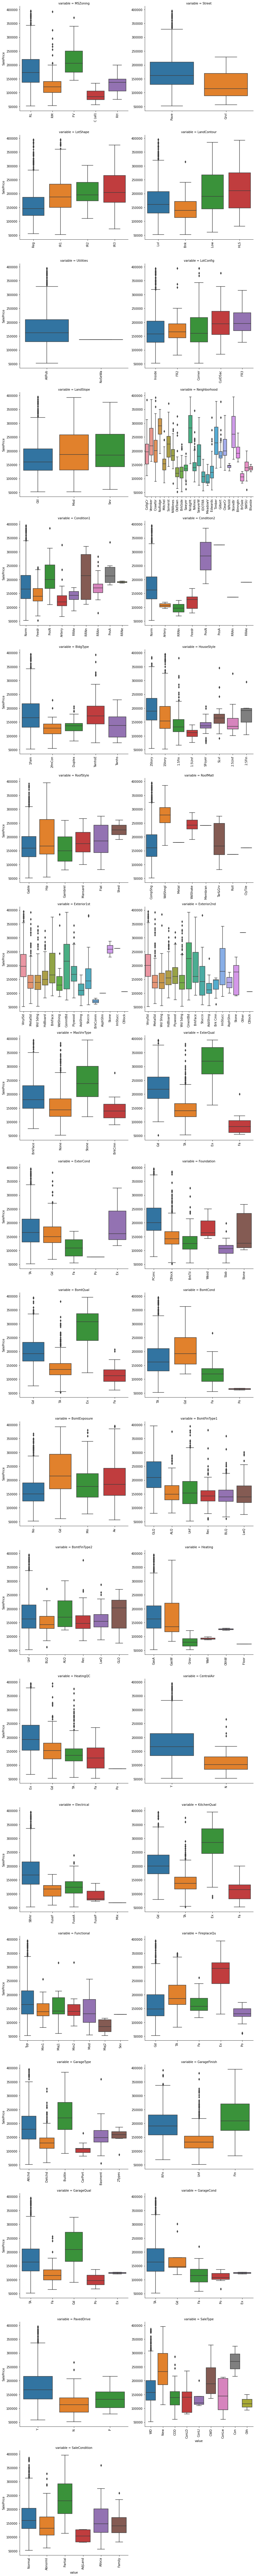

In [4]:
for c in ql:
    train[c] = train[c].astype('category')
    if train[c].isnull().any():
        train[c] = train[c].cat.add_categories(['MISSING'])
        train[c] = train[c].fillna('MISSING')
        
def boxplot(x,y,**kwargs):
    sns.boxplot(x=x, y=y)
    x = plt.xticks(rotation = 90)
f = pd.melt(train, id_vars=['SalePrice'], value_vars=ql)
g = sns.FacetGrid(f, col='variable', col_wrap=2, sharex=False, sharey=False, height=6)
g = g.map(boxplot, 'value', 'SalePrice')

Анализируя эти графики, можно сделать некоторое выводы о влиянии различных параметров на цену.
Параметры, значения которых сильно влияют на цену: MsZoning, Street, Utilities, Neighborgood, Condition1, Condition2, BldgType, RoofMatl, Exterior1st, Exterior2nd, MasnVnrType, ExterQual,  Foundation, BsmtQual, BsmtCond, BsmtFinType1, Heating, HeatingQC, CentralAir, KitchenQual, FireplaceQu, GarageType, GarageFinish, GarageQual, SaleType, SaleCondition.
Параметры, значения которых слабо влияют на цену: LotShape, LandContour, LotConfig, LandSlope, HouseStyle, RoofStyle, ExterCond, BsmtExposure,  BsmtFinType2, Electrical, Functional, GarageCond, PavedDrive.

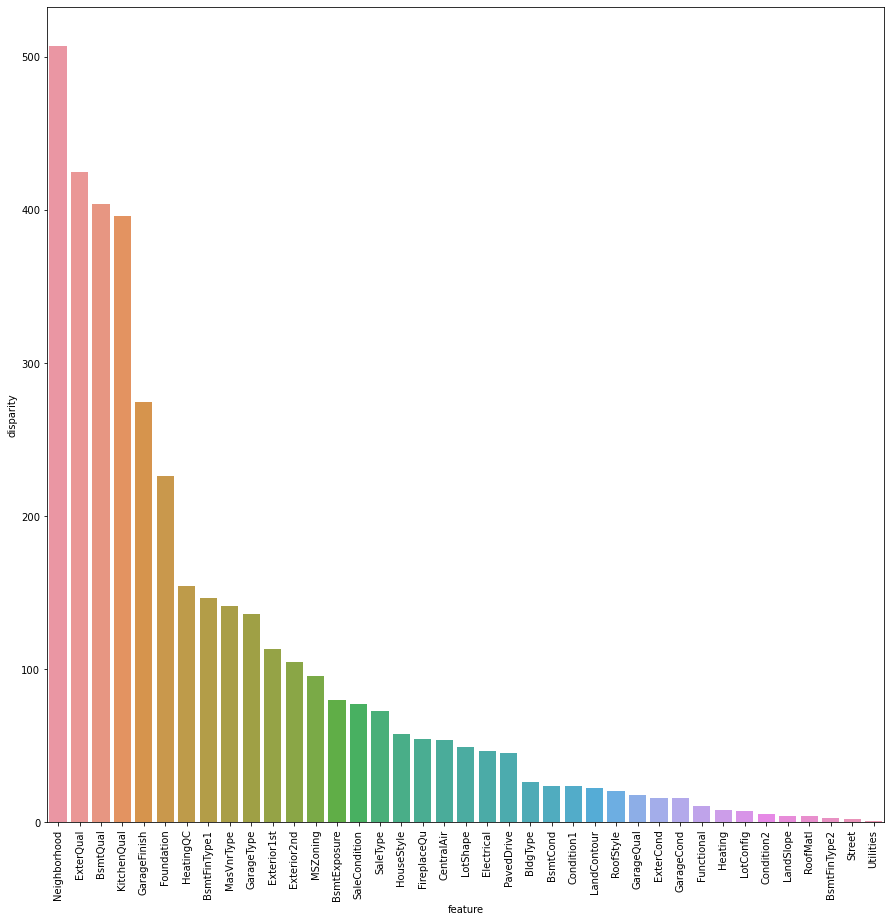

In [5]:
def anova(frame):
    anv = pd.DataFrame()
    anv['feature'] = ql
    pvals = []
    for c in ql:
        samples = []
        for cls in frame[c].unique():
            s = frame[frame[c] == cls]['SalePrice'].values
            samples.append(s)
        pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    return anv.sort_values('pval')

a = anova(train)
a['disparity'] = np.log(1./a['pval'].values)
plt.figure(figsize=(15, 15))
sns.barplot(data=a, x='feature', y='disparity')
x=plt.xticks(rotation=90)

Этот график демонстрирует оценку влияния параметров на цену путём сравнения разброса значений внутри параметра. Что в целом подтверждает изложенные выше выводы. Параметры, которые больше всего влияют на цену: Neighborhood, ExterQual, BsmtQual, KitchenQual. Исключением является пожалуй Utilities, т.к. там меньше всего разнообразие значений.

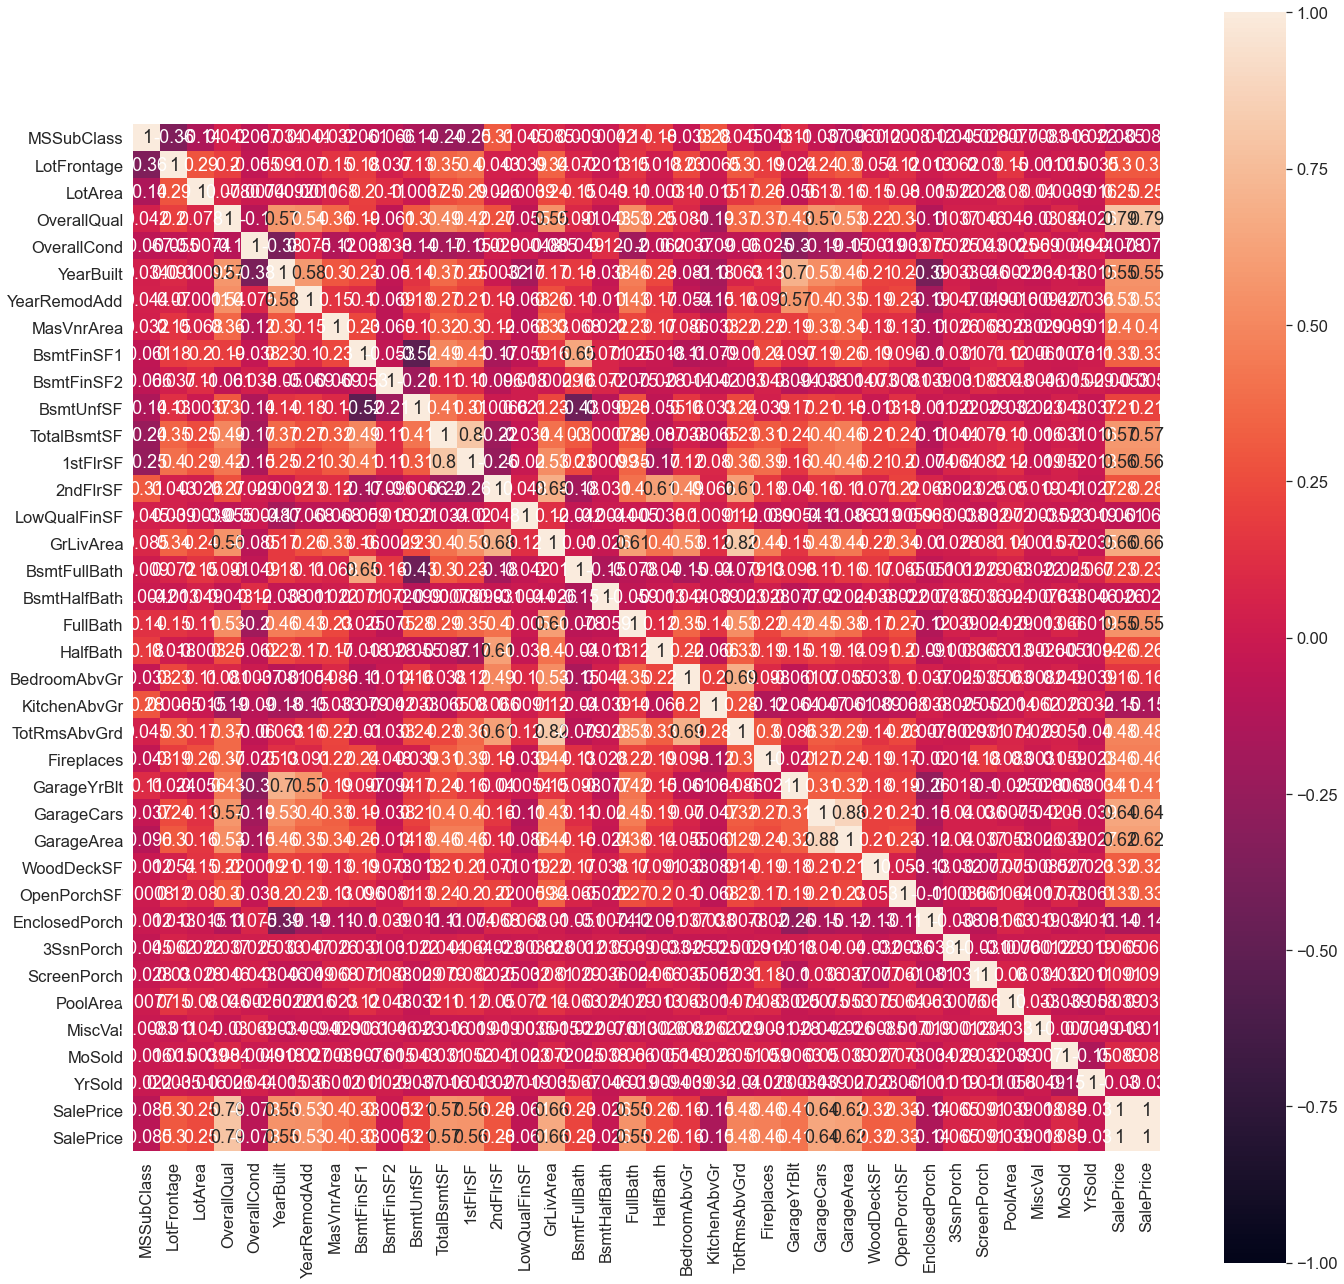

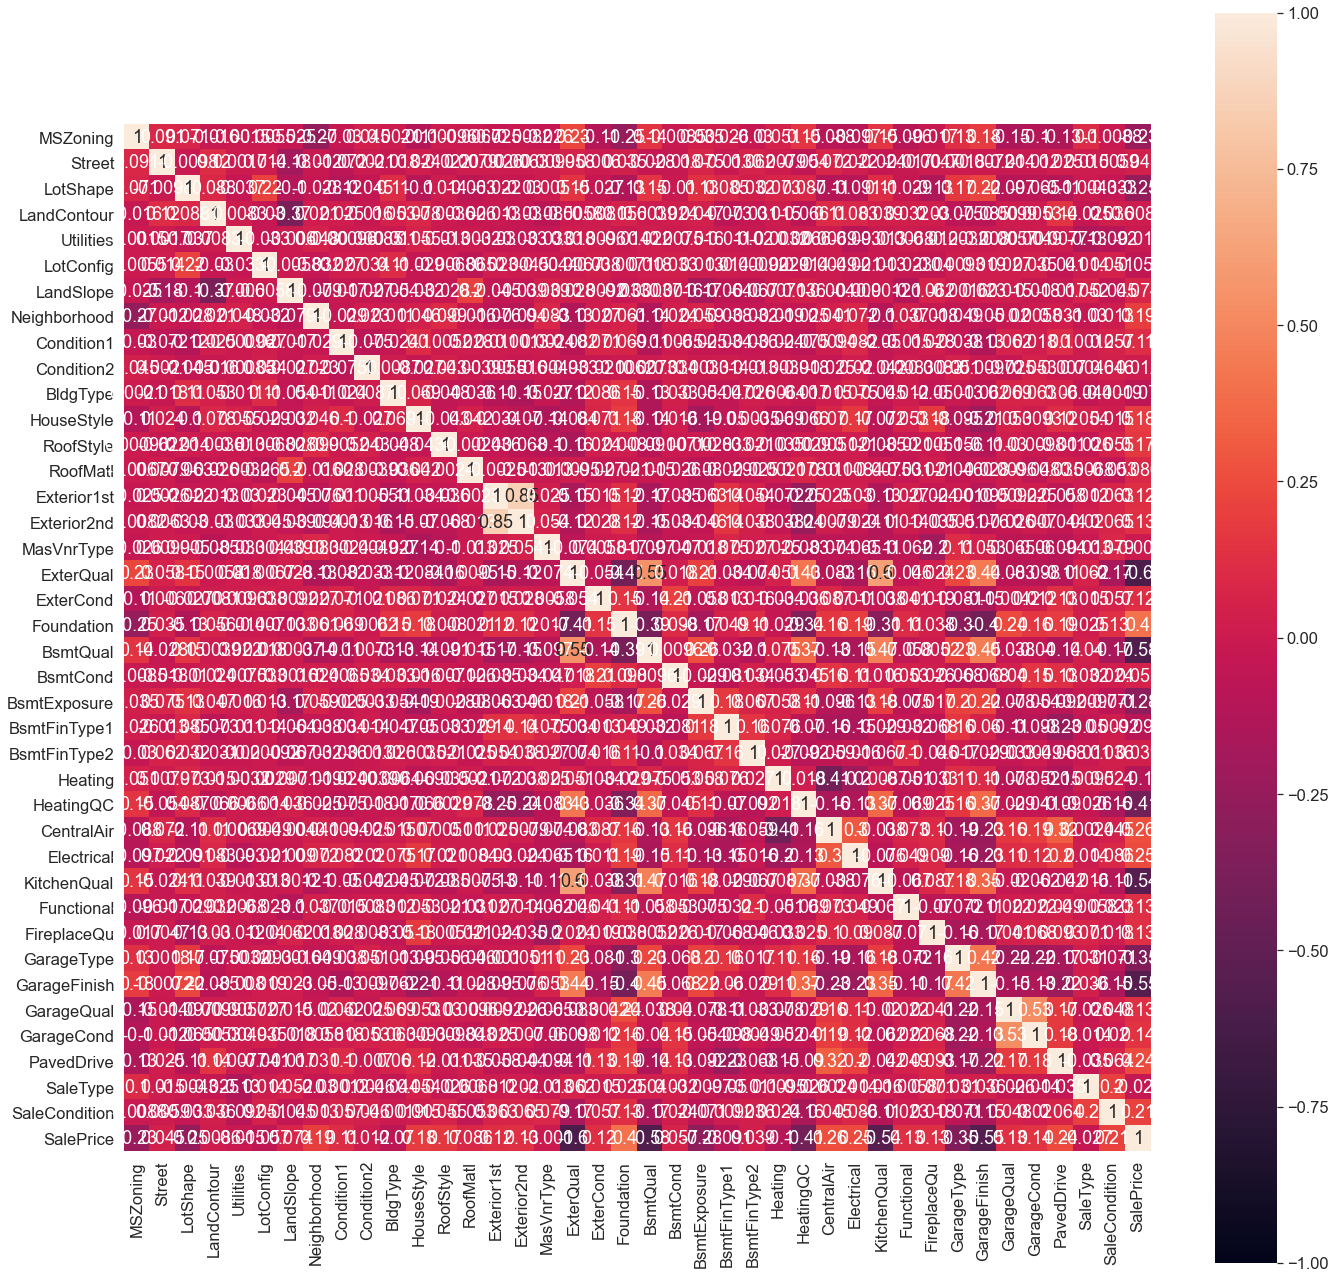

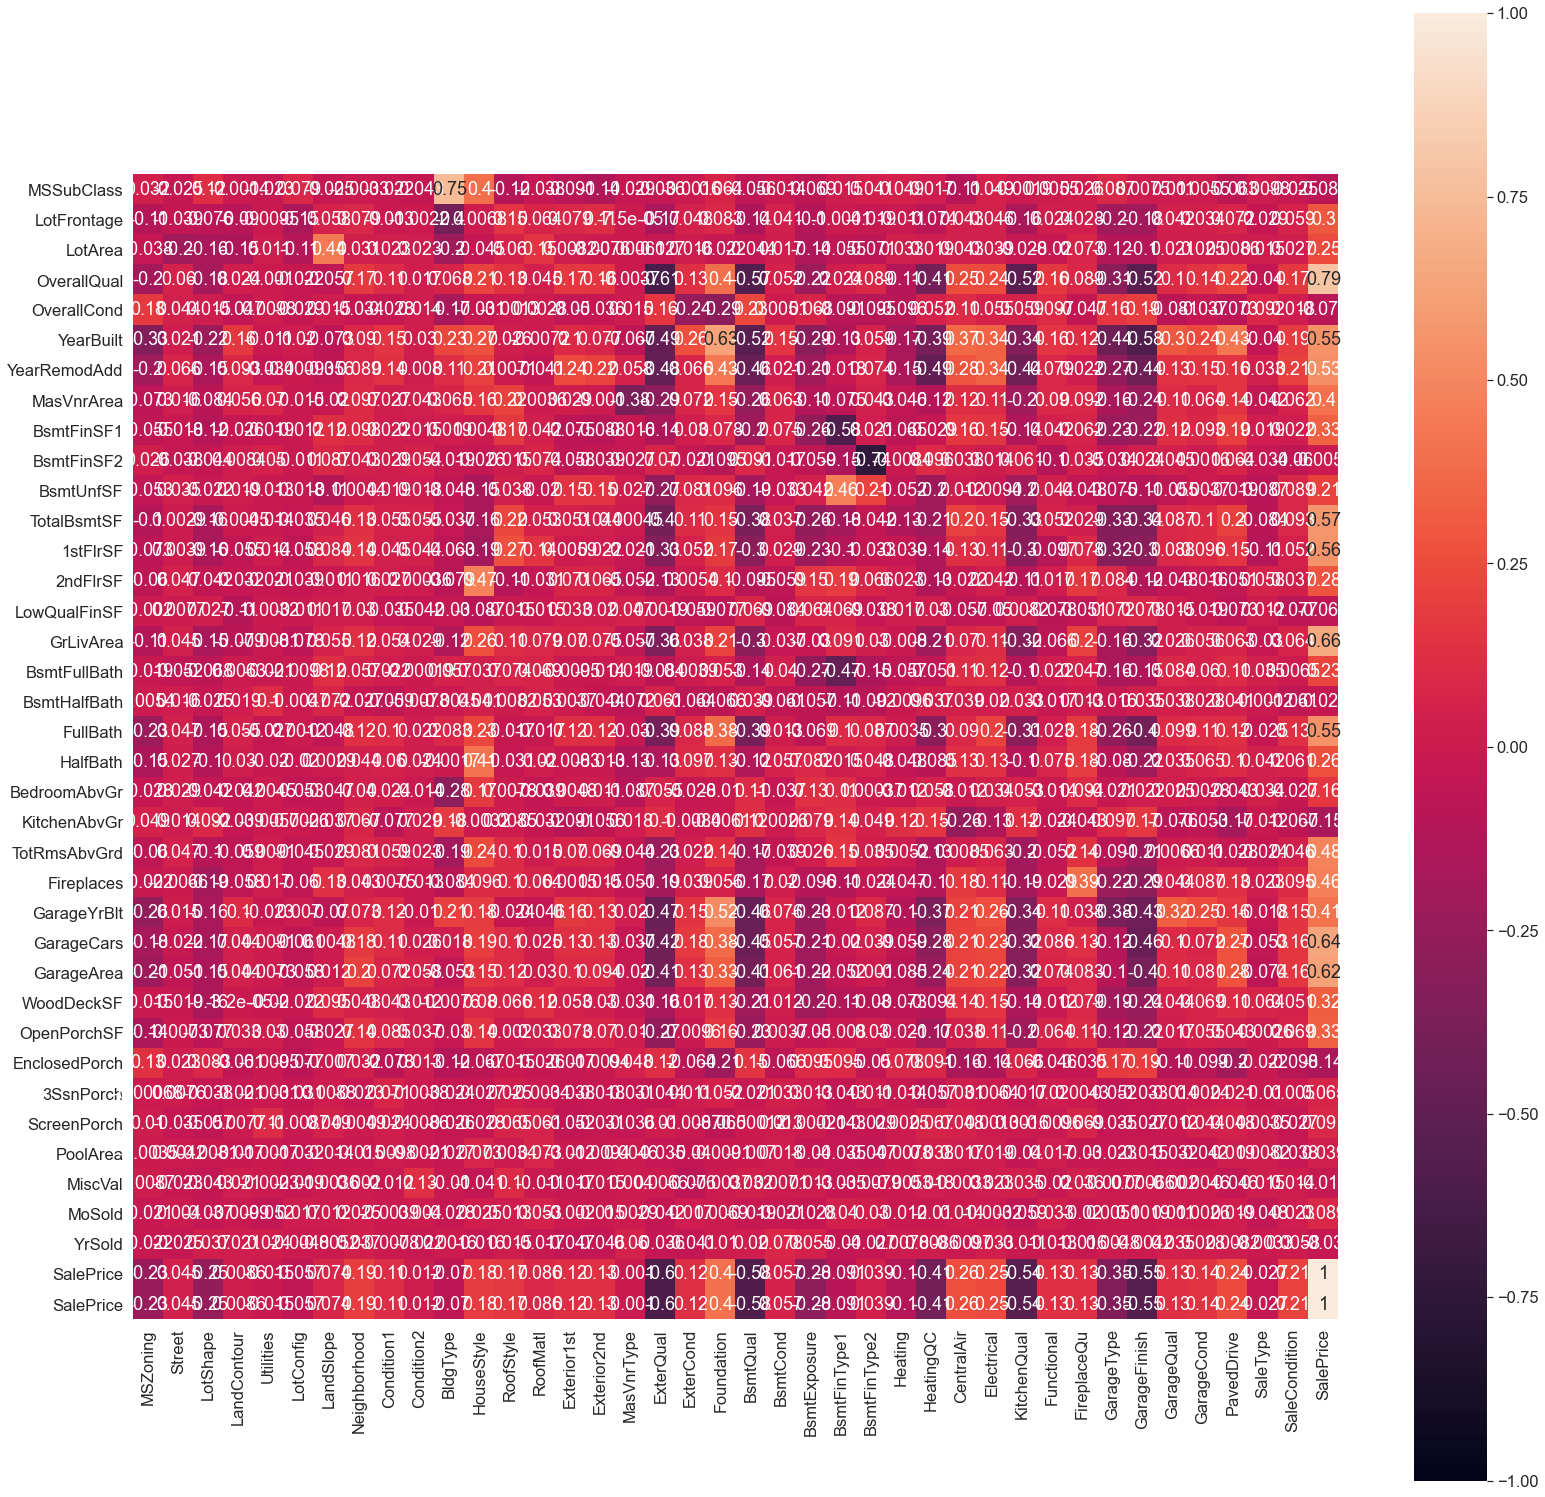

In [6]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in ql:
    train[col] = le.fit_transform(train[col])
for ct_test in qltest:
    test[ct_test] = le.fit_transform(test[ct_test])

plt.figure(1, figsize=(23, 23))
corr = train[qn+['SalePrice']].corr()
sns.set(font_scale=1.5)
sns.heatmap(corr, vmin=-1, vmax=1, square=True, annot=True)
plt.figure(2, figsize=(23, 23))
corr = train[ql+['SalePrice']].corr()
sns.heatmap(corr, vmin=-1, vmax=1, square=True, annot=True)
plt.figure(3, figsize=(27,27))
corr = pd.DataFrame(np.zeros([len(qn)+1, len(ql)+1]), index=qn+['SalePrice'], columns=ql+['SalePrice'])
for q1 in qn+['SalePrice']:
    for q2 in ql+['SalePrice']:
        corr.loc[q1, q2] = train[q1].corr(train[q2])
sns.heatmap(corr, vmin=-1, vmax=1, square=True, annot=True)

По полученным Heatmap можно говорить о корреляции между параметрами. 
Из первого графика, который соответсвует количественным параметрам видно, что между собой коррелируют год постройки и дата реконструкции (YearBuilt и YearRemodAdd), площадь подвала и площадь первого этажа (TotalBsmtSF и 1stFloorSF), количество комнат и жилая площадь (TotRmsAbvGrd и GrLivArea), количество мест в гараже и площадь гаража (GarageCars и GarageArea).
Из второго графика, который соответствует качественным параметром можно сказать о корреляции следующих параметров: экстерьер 1 и экстерьер 2 (Exterior1st и Exterior2nd), качество и состояние гаража (GarageQual и GarageCond), качество экстерьера и качество кухни (ExterQual и KitchenQual), качество подвала и тип фундамента (BsmtQual и Foundation), завершённость гаража и тип гаража (GarageFinish и GarageType).
Третий график демонстрирует корреляцию между качественными и количественными параметрами. Параметры, которые коррелируют между собой следующие: площадь бассейна и его качество (PoolArea и PoolQC), количество каминов и их качество (Fireplaces и  FireplacesQu), общая оценка материалов и завершённости дома и качество экстерьера (OverallQual и ExterQual), классификация жилья и тип жилья (MSSubClass и BldgType).
Исходя из всего вышесказанного следует удалить данные, которые больше всего коррелируют. Это будет: GarageCars (останется GarageArea), YearRemodAdd (YearBuilt), TotalBsmtSF (1stFloorSF), TotRmsAbvGrd (GrLivArea), Exterior2nd (Exterior1st).

In [7]:
c_drop2 = ['GarageCars', 'YearRemodAdd', 'TotalBsmtSF', 'TotRmsAbvGrd', 'Exterior2nd']
train.drop(columns=c_drop2, inplace=True)
test.drop(columns=c_drop2, inplace=True)

In [8]:
X_train = train.iloc[: , :-1].values
y_train = train.iloc[: , -1].values
X_test = test.iloc[: , :].values
X_train,X_test,y_train,y_test = train_test_split(X_train,y_train,random_state=0,test_size=0.25)

In [15]:
print(y_train)

[189000 160000 167000 ... 169900 118500 213000]


In [10]:
regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(X_train,y_train)

DecisionTreeRegressor(random_state=0)

In [11]:
y_pred = regressor.predict(X_test).reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [12]:
errors = abs(y_pred - y_test)
mape = 100*(errors/y_test)
accuracy = 100 - np.mean(mape)
print('Точность: ', round(accuracy, 5), '%')

Точность:  84.84106 %


In [1]:
test = np.nan_to_num(test)
predictions = regressor.predict(test)
predictions.shape
sample['SalePrice'] = predictions.astype(float)
sample.to_csv('D:/houseprices/Final.csv')
print(sample)

NameError: name 'np' is not defined

In [8]:
import numpy as np
df = np.arange(12).reshape(3,4)
df


array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])

In [18]:
df[1:2,:]

array([[False, False, False, False],
       [False, False, False, False],
       [False, False, False, False]])

Вывод: используя модель дерево решений были получены цены продажи домов для тестового задания. Была оценена точность, которая получилась 84.8%. Т.е. достаточно большая погрешность. Для построения модели были подготовленны данные исходя из промежуточных результатов, т.е. удалены различные столбцы и строки, чтобы уменьшить "мусор". 
Для получения более высокой точности требуется дополнительные исследования.